In [2]:
from util import *

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import xgboost as xgb
import pickle

from scipy import stats
from xgboost import XGBRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, make_scorer
from sklearn.model_selection import KFold
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.decomposition import PCA
from joblib import dump, load

In [66]:
data_log, data_dash = get_data_frames()
result_total, labels = get_data_concated(data_log, data_dash)

### Split Swithes

In [6]:
switch3 = (
    result_total[
        [
            "timestamp",
            "ingress_global_timestamp3",
            "egress_global_timestamp3",
            "enq_timestamp3",
            "enq_qdepth3",
            "deq_timedelta3",
            "deq_qdepth3",
        ]
    ]
)
switch2 = (
    result_total[
        [
            "timestamp",
            "ingress_global_timestamp2",
            "egress_global_timestamp2",
            "enq_timestamp2",
            "enq_qdepth2",
            "deq_timedelta2",
            "deq_qdepth2",
        ]
    ]
)
switch1 = (
    result_total[
        [
            "timestamp",
            "ingress_global_timestamp1",
            "egress_global_timestamp1",
            "enq_timestamp1",
            "enq_qdepth1",
            "deq_timedelta1",
            "deq_qdepth1",
        ]
    ]
)

In [41]:
def show_something(y1, z1, x1):
    data = {
        "Switch": switches,
        "RF_MAE": y1[:4],
        "RF_NMAE": y1[:4],
        "XGB_MAE": z1[:4],
        "XGB_NMAE": z1[:4],
    }
    df = pd.DataFrame(data)

    bar_width = 0.35
    r1 = range(len(df))
    r2 = [x + bar_width for x in r1]

    fig, ax = plt.subplots()
    bars_rf = ax.bar(
        r1, df["RF_NMAE"], color="blue", width=bar_width, edgecolor="white", label="RF"
    )
    bars_xgb = ax.bar(
        r2, df["XGB_NMAE"], color="red", width=bar_width, edgecolor="white", label="XGB"
    )

    ax.set_xlabel("Switch")
    ax.set_ylabel("NMAE (%)")
    ax.set_xticks([r + bar_width / 2 for r in range(len(df))])
    ax.set_xticklabels(df["Switch"])
    ax.legend()

    for bar in bars_rf:
        yval = bar.get_height()
        ax.text(
            bar.get_x() + bar.get_width() / 2,
            yval - 0.1,
            f"{yval:.1f}%",
            ha="center",
            va="bottom",
        )

    for bar in bars_xgb:
        yval = bar.get_height()
        ax.text(
            bar.get_x() + bar.get_width() / 2,
            yval - 0.1,
            f"{yval:.1f}%",
            ha="center",
            va="bottom",
        )
    plt.savefig("10EnqParamRFvsXGB.png", dpi=fig.dpi)
    plt.show()
   

### Models

In [11]:
def rf_train_model(features, labels):
    X_train, X_validation, y_train, y_validation = train_test_split(
        features,
        np.ravel(labels),
        test_size=0.20,
        random_state=42
    )

    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_validation_scaled = scaler.transform(X_validation)

    rf_model = RandomForestRegressor(
        # n_estimators=500,
        # max_depth=50,
        # min_samples_split=2,
        # min_samples_leaf=1,
        bootstrap=True,
        # verbose=0,
        # max_features=1.0,
        # n_jobs=2,
        random_state=42
    )

    mae_scorer = make_scorer(mean_absolute_error, greater_is_better=False)
    kf = KFold(n_splits=3, shuffle=True, random_state=42)

    cv_scores = cross_val_score(
        rf_model,
        X_train_scaled,
        y_train,
        cv=kf,
        scoring=mae_scorer
    )

    avg_cv_score = np.mean(cv_scores)

    rf_model.fit(X_train_scaled, y_train)

    y_pred_rf = rf_model.predict(X_validation_scaled)
    mae_rf = mean_absolute_error(y_validation, y_pred_rf)
    nmae_rf = mae_rf / np.mean(y_validation)

    feature_importances = rf_model.feature_importances_
    
    return mae_rf, nmae_rf, rf_model, feature_importances

In [46]:
def xgb_train_model(dataOver, answer):
    X_train, X_validation, y_train, y_validation = train_test_split(
        dataOver,
        np.ravel(answer),
        test_size=0.30,
        random_state=42
    )

    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_validation_scaled = scaler.transform(X_validation)

    xgb_model = XGBRegressor(
        # n_estimators=1000,
        # learning_rate=0.01,  
        # max_depth=30, 
        # n_jobs=2,
        random_state=42
    )

    mae_scorer = make_scorer(mean_absolute_error, greater_is_better=False)
    kf = KFold(n_splits=5, shuffle=True, random_state=42)

    cv_scores = cross_val_score(
        xgb_model,
        X_train_scaled,
        y_train,
        cv=kf,
        scoring=mae_scorer
    )
    avg_cv_score = np.mean(cv_scores)

    xgb_model.fit(
        X_train_scaled,
        y_train,
        eval_set=[(X_validation_scaled, y_validation)],
        verbose=False
    )

    y_pred = xgb_model.predict(X_validation_scaled)
    mae = mean_absolute_error(y_validation, y_pred)
    nmae = mae / np.mean(y_validation)

    feature_importances = xgb_model.feature_importances_
    return mae, nmae, xgb_model, feature_importances

### Tests

Switch 1 RF-> MAE: 5.866, NMAE: 29.138%
Switch 2 RF-> MAE: 5.792, NMAE: 28.769%
Switch 3 RF-> MAE: 5.813, NMAE: 28.876%
Total RF-> MAE: 5.848, NMAE: 29.049%
[0]	validation_0-rmse:10.78911
[1]	validation_0-rmse:10.40560
[2]	validation_0-rmse:10.26195
[3]	validation_0-rmse:10.18563
[4]	validation_0-rmse:10.09765
[5]	validation_0-rmse:10.00291
[6]	validation_0-rmse:9.99165
[7]	validation_0-rmse:9.96850
[8]	validation_0-rmse:9.92943
[9]	validation_0-rmse:9.86252
[10]	validation_0-rmse:9.83086
[11]	validation_0-rmse:9.82433
[12]	validation_0-rmse:9.75944
[13]	validation_0-rmse:9.73578
[14]	validation_0-rmse:9.70376
[15]	validation_0-rmse:9.68400
[16]	validation_0-rmse:9.65014
[17]	validation_0-rmse:9.62824
[18]	validation_0-rmse:9.60841
[19]	validation_0-rmse:9.59050
[20]	validation_0-rmse:9.58396
[21]	validation_0-rmse:9.56166
[22]	validation_0-rmse:9.56345
[23]	validation_0-rmse:9.56504
[24]	validation_0-rmse:9.52697
[25]	validation_0-rmse:9.53081
[26]	validation_0-rmse:9.50733
[27]	valid

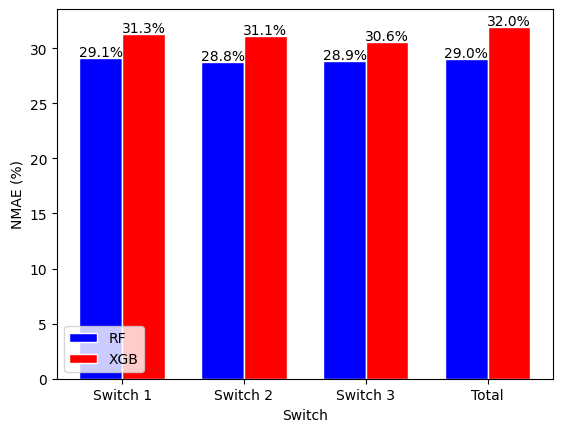

<Figure size 640x480 with 0 Axes>

In [16]:
switches = ["Switch 1", "Switch 2", "Switch 3", "Total"]
x1 = [1, 2, 3, 4]
y1, z1 = [], []

result_ = result_total.copy(True)
models = {
    "RF": [],
    "XGB": []
}
feature_importances = {
    "RF": [],
    "XGB": []
}
results_rf = [switch1, switch2, switch3, result_]
results_xgb = [switch1, switch2, switch3, result_]

def collect_metrics(train_func, results, y_list, model_name):
    for i, result in enumerate(results):
        mae, nmae, model, feature_importance = train_func(result, labels)
        y_list.append(nmae * 100)
        models[model_name].append(model)
        feature_importances[model_name].append(feature_importance)
        print(f"{switches[i]} {model_name}-> MAE: {mae:.3f}, NMAE: {nmae * 100:.3f}%")
try:
    collect_metrics(rf_train_model, results_rf, y1, "RF")
    collect_metrics(xgb_train_model, results_xgb, z1, "XGB")
    show_something(x1=x1, y1=y1, z1=z1)
    alert_end()
except Exception as e:
    alert_end()


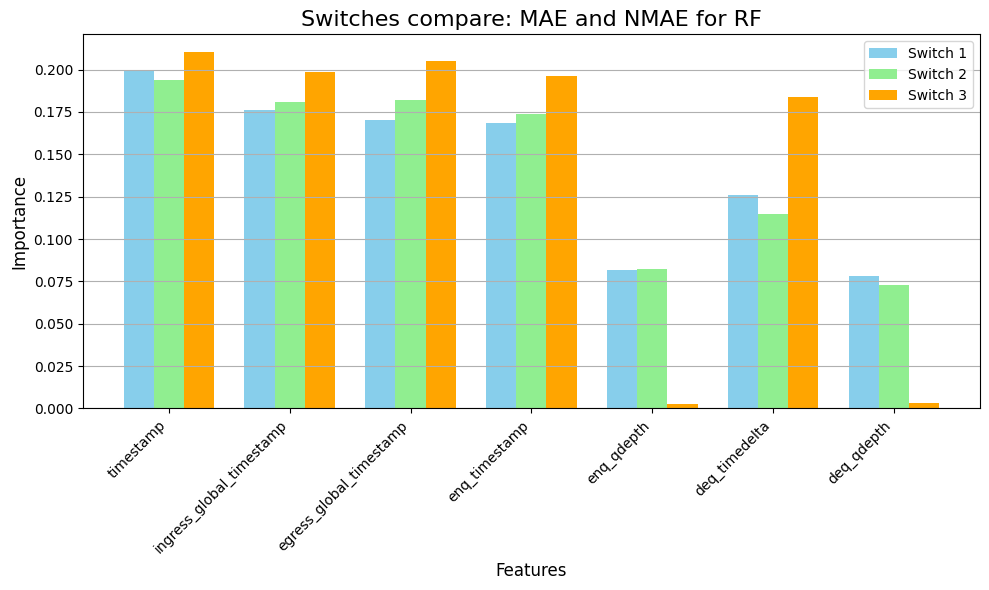

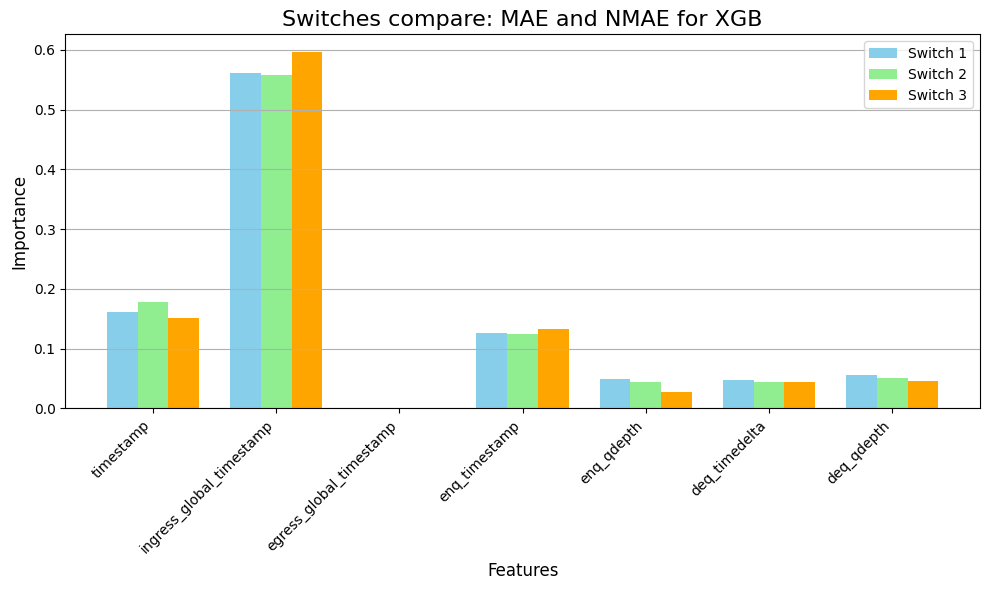

In [47]:
import numpy as np
import matplotlib.pyplot as plt

labels = ['timestamp', 'ingress_global_timestamp', 'egress_global_timestamp', 
          'enq_timestamp', 'enq_qdepth', 'deq_timedelta', 'deq_qdepth']

def plot_feature_importance(switch_features, model_name):
    x = np.arange(len(labels))  
    width = 0.25  

    fig, ax = plt.subplots(figsize=(10, 6)) 

    ax.bar(x - width, switch_features[0], width, label='Switch 1', color='skyblue')
    ax.bar(x, switch_features[1], width, label='Switch 2', color='lightgreen')
    ax.bar(x + width, switch_features[2], width, label='Switch 3', color='orange')

    ax.set_xlabel('Features', fontsize=12)
    ax.set_ylabel('Importance', fontsize=12)
    ax.set_title(f'Switches compare: MAE and NMAE for {model_name}', fontsize=16)

    ax.set_xticks(x)
    ax.set_xticklabels(labels, rotation=45, ha='right')

    ax.legend()
    ax.grid(True, axis='y')

    plt.tight_layout()
    plt.savefig(f"FeatureImportance_10xenq{model_name}.png", dpi=fig.dpi)


plot_feature_importance(feature_importances['RF'], 'RF')
plot_feature_importance(feature_importances['XGB'], 'XGB')

plt.show()

### Feature Engineering

In [40]:
switch1_ = switch1.copy(True)
switch2_ = switch2.copy(True)
switch3_ = switch3.copy(True)

switch1_['enq_qdepth1'] *= 10
switch1_['enq_timestamp1'] *= 10
switch2_['enq_qdepth2'] *= 10
switch2_['enq_timestamp2'] *= 10
switch3_['enq_qdepth2'] *= 10
switch3_['enq_timestamp2'] *= 10


,timestamp,ingress_global_timestamp1,egress_global_timestamp1,enq_timestamp1,enq_qdepth1,deq_timedelta1,deq_qdepth1
0,1621899282,3.924525e+10,3.924525e+10,5.905407e+09,0.000000,32.400000,0.000000
1,1621899283,3.924598e+10,3.924598e+10,5.912778e+09,0.000000,30.333333,0.000000
2,1621899284,3.924709e+10,3.924709e+10,5.923834e+09,0.000000,31.166667,0.000000
3,1621899285,3.924808e+10,3.924808e+10,5.933725e+09,0.000000,28.285714,0.000000
4,1621899286,3.924903e+10,3.924903e+10,5.943283e+09,0.000000,32.666667,0.000000
...,...,...,...,...,...,...,...
32247,1621927359,5.537510e+10,5.537510e+10,2.116211e+10,13.947356,959.173138,1.078428
32248,1621931540,5.537510e+10,5.537510e+10,2.116211e+10,13.947356,959.173138,1.078428
32249,1621931541,5.537510e+10,5.537510e+10,2.116211e+10,13.947356,959.173138,1.078428
32250,1621931542,5.537510e+10,5.537510e+10,2.116211e+10,13.947356,959.173138,1.078428


Switch 1 RF-> MAE: 5.866, NMAE: 29.138%
Switch 2 RF-> MAE: 5.792, NMAE: 28.769%
Switch 3 RF-> MAE: 5.813, NMAE: 28.876%
Total RF-> MAE: 5.848, NMAE: 29.049%
[0]	validation_0-rmse:10.78911
[1]	validation_0-rmse:10.40560
[2]	validation_0-rmse:10.26195
[3]	validation_0-rmse:10.18563
[4]	validation_0-rmse:10.09765
[5]	validation_0-rmse:10.00291
[6]	validation_0-rmse:9.99165
[7]	validation_0-rmse:9.96850
[8]	validation_0-rmse:9.92943
[9]	validation_0-rmse:9.86252
[10]	validation_0-rmse:9.83086
[11]	validation_0-rmse:9.82433
[12]	validation_0-rmse:9.75944
[13]	validation_0-rmse:9.73578
[14]	validation_0-rmse:9.70376
[15]	validation_0-rmse:9.68400
[16]	validation_0-rmse:9.65014
[17]	validation_0-rmse:9.62824
[18]	validation_0-rmse:9.60841
[19]	validation_0-rmse:9.59050
[20]	validation_0-rmse:9.58396
[21]	validation_0-rmse:9.56166
[22]	validation_0-rmse:9.56345
[23]	validation_0-rmse:9.56504
[24]	validation_0-rmse:9.52697
[25]	validation_0-rmse:9.53081
[26]	validation_0-rmse:9.50733
[27]	valid

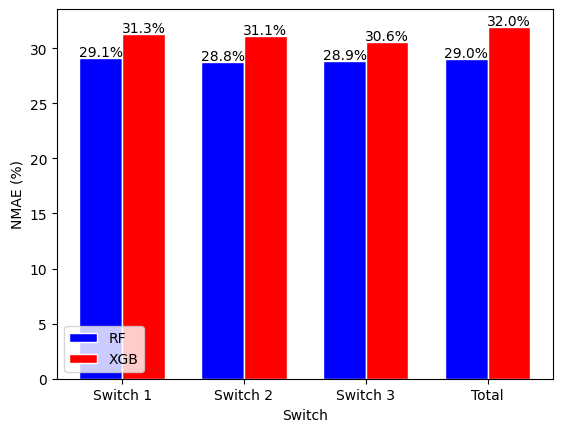

In [45]:
switches = ["Switch 1", "Switch 2", "Switch 3", "Total"]
x1 = [1, 2, 3, 4]
y1, z1 = [], []

result_ = result_total.copy(True)
models = {
    "RF": [],
    "XGB": []
}
feature_importances = {
    "RF": [],
    "XGB": []
}
results_rf = [switch1_, switch2_, switch3_, result_]
results_xgb = [switch1_, switch2_, switch3_, result_]

def collect_metrics(train_func, results, y_list, model_name):
    for i, result in enumerate(results):
        mae, nmae, model, feature_importance = train_func(result, labels)
        y_list.append(nmae * 100)
        models[model_name].append(model)
        feature_importances[model_name].append(feature_importance)
        print(f"{switches[i]} {model_name}-> MAE: {mae:.3f}, NMAE: {nmae * 100:.3f}%")
try:
    collect_metrics(rf_train_model, results_rf, y1, "RF")
    collect_metrics(xgb_train_model, results_xgb, z1, "XGB")
    show_something(x1=x1, y1=y1, z1=z1)
    alert_end()
except Exception as e:
    print(e)
    alert_end()


In [51]:
tree = models['RF'][3].estimators_[0]

n_nodes = tree.tree_.node_count
impurity = tree.tree_.impurity
samples_per_node = tree.tree_.n_node_samples 

for node in range(10,20):
    print(f"Nó {node}: Impureza = {impurity[node]}, Amostras = {samples_per_node[node]}")

Nó 10: Impureza = 40.73829359379488, Amostras = 37
Nó 11: Impureza = 36.25170068027211, Amostras = 27
Nó 12: Impureza = 25.208448117539007, Amostras = 22
Nó 13: Impureza = 19.883454734651394, Amostras = 21
Nó 14: Impureza = 12.653983353150977, Amostras = 19
Nó 15: Impureza = 5.411764705882376, Amostras = 13
Nó 16: Impureza = 4.9917355371900385, Amostras = 9
Nó 17: Impureza = 2.8000000000000114, Amostras = 4
Nó 18: Impureza = 0.0, Amostras = 2
Nó 19: Impureza = 0.22222222222222854, Amostras = 2


In [53]:
xgb_model = models['XGB'][3]
booster = xgb_model.get_booster()
importance = booster.get_score(importance_type='gain')

# Exibindo o "gain" (grau de pureza) de cada feature
for feature, score in importance.items():
    print(f"Feature: {feature}, Gain: {score}")

Feature: f0, Gain (pureza): 786.53173828125
Feature: f1, Gain (pureza): 3628.705322265625
Feature: f3, Gain (pureza): 803.6373901367188
Feature: f4, Gain (pureza): 169.0322265625
Feature: f5, Gain (pureza): 254.89822387695312
Feature: f6, Gain (pureza): 308.7217712402344
Feature: f7, Gain (pureza): 231.9488525390625
Feature: f9, Gain (pureza): 803.7064208984375
Feature: f10, Gain (pureza): 252.188232421875
Feature: f11, Gain (pureza): 281.5235595703125
Feature: f12, Gain (pureza): 262.4684143066406
Feature: f15, Gain (pureza): 686.6378173828125
Feature: f16, Gain (pureza): 285.6169738769531
Feature: f17, Gain (pureza): 312.05889892578125
Feature: f18, Gain (pureza): 300.6531982421875


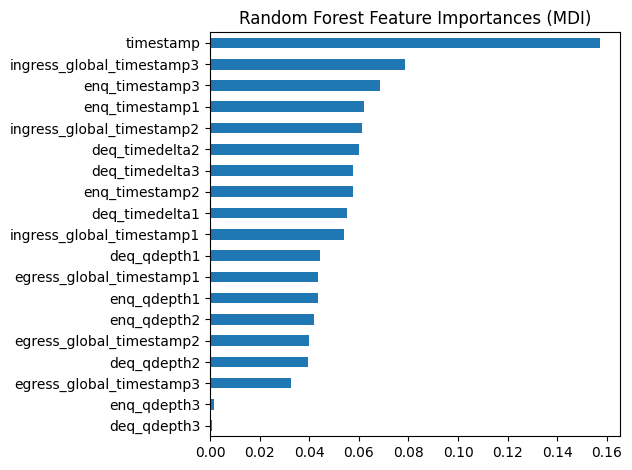

In [57]:
feature_names = result_total.columns 

mdi_importances = pd.Series(
    tree.feature_importances_, index=feature_names
).sort_values(ascending=True)

ax = mdi_importances.plot.barh()
ax.set_title("Random Forest Feature Importances (MDI)")
ax.figure.tight_layout()
plt.show()
